<a href="https://colab.research.google.com/github/WalterLops/pipeline_bert_qa/blob/main/Pipeline_BERT_Q%26A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pipelines Q&A com modelo LLM BERT fine-tuned

## Montando o Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Definições iniciais


In [ ]:
import time
from datetime import datetime
import pytz
import threading
import importlib
import subprocess
import sys
import torch
import pkg_resources

def imprimir_tempo_execucao(start_time):
    end_time = time.time()
    execution_time = end_time - start_time
    horas, resto = divmod(execution_time, 3600)
    minutos, segundos = divmod(resto, 60)
    print(f'Tempo total de execução: {int(horas):02d}:{int(minutos):02d}:{int(segundos):02d}')

def imprimir_ultima_execucao():
    fuso_horario = pytz.timezone('America/Sao_Paulo')
    agora = datetime.now(fuso_horario)
    print("Última execução:", agora.strftime("%d/%m/%Y %H:%M:%S"))

In [ ]:
def green(text):
    return f"\033[92m{text}\033[0m"

def red(text):
    return f"\033[91m{text}\033[0m"

def blue(text):
    return f"\033[94m{text}\033[0m"

def install_package(package, version=None):
    package_name = package.lower()
    installed_packages = {pkg.key for pkg in pkg_resources.working_set}

    print(green(f"Instalando {package} agora..."))

    try:
        if version:
            subprocess.check_call([sys.executable, "-m", "pip", "install", f"{package}=={version}"])
        else:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    except subprocess.CalledProcessError:
        print(red(f"Erro ao instalar {package}."))

def import_module(package, module=None, classe=None):
    try:
        if module:
            print(blue(f"Importado com sucesso: {package}.{module}"))
            module_obj = importlib.import_module(f"{package}.{module}")
        else:
            print(blue(f"Importado com sucesso: {package}"))
            module_obj = importlib.import_module(package)

        if classe:
            try:
                class_obj = getattr(module_obj, classe)
                print(blue(f"Classe {classe} importada com sucesso."))
                return class_obj
            except AttributeError:
                print(red(f"Classe {classe} não encontrada em {package}.{module}" if module else f"Classe {classe} não encontrada em {package}"))
                return None
        else:
            return module_obj
    except ImportError as e:
        print(red(f"Não foi possível importar {package}.{module}" if module else f"Não foi possível importar {package}"))
        print(red(str(e)))
        return None


## Diretórios

In [ ]:
# Caminhos para o modelo e tokenizador
model_base_path = "..."
tokenizer_base_path = "..."
source_base_model = "pierreguillou/bert-base-cased-squad-v1.1-portuguese"

model_large_path = "..."
tokenizer_large_path = "..."
source_large_model = "pierreguillou/bert-large-cased-squad-v1.1-portuguese"

# Diretório com os arquivos PDF
pdf_directory = "..."

# Configurações do WebSocket
path_config_ws = '../config_ws.json'

imprimir_ultima_execucao()

## Carregando o modelo

In [ ]:
import os
from transformers import BertTokenizer, BertForQuestionAnswering

class ModelosBERT:
    def __init__(self, model_base_url, dir_model_base, dir_tokenizer_base, model_large_url, dir_model_large, dir_tokenizer_large):
        self._model_base_url = model_base_url
        self._dir_model_base = dir_model_base
        self._dir_tokenizer_base = dir_tokenizer_base
        self._model_large_url = model_large_url
        self._dir_model_large = dir_model_large
        self._dir_tokenizer_large = dir_tokenizer_large
        self.tokenizer_base = None
        self.model_base = None
        self.tokenizer_large = None
        self.model_large = None

    def _carregar_modelo_e_tokenizador(self, model_url, model_path, tokenizer_path):
        os.makedirs(model_path, exist_ok=True)
        os.makedirs(tokenizer_path, exist_ok=True)

        if not os.listdir(model_path) or not os.listdir(tokenizer_path):
            print("Modelo e tokenizador não encontrados localmente. Fazendo download...")
            tokenizer = BertTokenizer.from_pretrained(model_url, cache_dir=tokenizer_path)
            model = BertForQuestionAnswering.from_pretrained(model_url, cache_dir=model_path)
            tokenizer.save_pretrained(tokenizer_path)
            model.save_pretrained(model_path)
        else:
            print("Carregando o modelo e o tokenizador do diretório local...")
            tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
            model = BertForQuestionAnswering.from_pretrained(model_path)

        print("O modelo e tokenizador foram carregados!")

        return tokenizer, model

    def _carregar_instance_modelo_base(self):
        if not self.tokenizer_base and not self.model_base:
            print("Carregando o modelo base...")
            self.tokenizer_base, self.model_base = self._carregar_modelo_e_tokenizador(
                self._model_base_url, self._dir_model_base, self._dir_tokenizer_base)
        return self

    def _carregar_instance_modelo_large(self):
        if not self.tokenizer_large and not self.model_large:
            print("Carregando o modelo large...")
            self.tokenizer_large, self.model_large = self._carregar_modelo_e_tokenizador(
                self._model_large_url, self._dir_model_large, self._dir_tokenizer_large)
        return self

    def _carregar_path_modelo_base(self):
        if not self.tokenizer_base and not self.model_base:
            print("Carregando o modelo base...")
            self.tokenizer_base, self.model_base = self._carregar_modelo_e_tokenizador(self._model_base_url, self._dir_model_base, self._dir_tokenizer_base)
        return self._dir_model_base, self._dir_tokenizer_base

    def _carregar_path_modelo_large(self):
        if not self.tokenizer_large and not self.model_large:
            print("Carregando o modelo large...")
            self.tokenizer_large, self.model_large = self._carregar_modelo_e_tokenizador(self._model_large_url, self._dir_model_large, self._dir_tokenizer_large)
        return self._dir_model_large, self._dir_tokenizer_large

    def get_instance_model_tokenize(self, type_model=1):
        '''
        param type_model -> 0 : base, 1 : large
        return model, tokenizer
        '''
        if(type_model==0):
          self._carregar_path_modelo_base()
          return self.model_base, self.tokenizer_base
        if (type_model==1):
          self._carregar_path_modelo_large()
          return self.model_large, self.tokenizer_large
        else:
          print(f"Erro: esse tipo de modelo não pode ser obtido. {type_model}")

    def get_patch_model_tokenize(self, type_model=1):
        '''
        param type_model -> 0 : base, 1 : large
        return model, tokenizer
        '''
        if(type_model==0):
          return self._carregar_path_modelo_base()

        if (type_model==1):
          return self._carregar_path_modelo_large()
        else:
          print(f"Erro: esse tipo de modelo não pode ser obtido. {type_model}")

## Instalação de pacotes pip

In [ ]:
start_time = time.time()
# Arquitetura modelo
!pip install transformers

In [ ]:
if torch.cuda.is_available():
    print('GPU disponível, instalando libs da pipe Haystack.')
    install_package('pdfplumber')
    install_package('farm-haystack')
else:
    print('GPU indisponível, instalando libs da pipe VectorDB.')
    install_package('git+https://github.com/vioshyvo/mrpt/')
    install_package('tf-keras', '2.16')
    install_package('vectordb2')
    install_package('langchain')
    install_package('nltk')
    install_package('PyMuPDF')
    install_package('tqdm')

GPU disponível, instalando libs da pipe Haystack.
Instalando pdfplumber agora...
Instalando farm-haystack agora...


In [ ]:
# WS
!pip install flask
!pip install pyngrok
!pip install flask-cors
!pip install Flask-SocketIO

imprimir_tempo_execucao(start_time)
#imprimir_ultima_execucao()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 8.3 MB/s eta 0:00:00
Tempo total de execução: 00:01:41


## Importações

In [ ]:
# Pipe Haystack
pdfplumber, clean_wiki_text, ExtractiveQAPipeline, InMemoryDocumentStore, TransformersReader = [None, None, None, None, None]

# Pipe VectorDB
Memory, text_splitter, nltk, fitz, tqdm = [None, None, None, None, None]

# Condição para verificar e instalar bibliotecas
if torch.cuda.is_available():
    print('GPU disponível, instalando libs da pipe Haystack.')
    pdfplumber = import_module('pdfplumber')
    clean_wiki_text = import_module('haystack', 'utils', 'clean_wiki_text')
    ExtractiveQAPipeline = import_module('haystack', 'pipelines', 'ExtractiveQAPipeline')
    InMemoryDocumentStore = import_module('haystack', 'document_stores', 'InMemoryDocumentStore')
    BM25Retriever = import_module('haystack', 'nodes', 'BM25Retriever')
    TransformersReader = import_module('haystack', 'nodes', 'TransformersReader')
else:
    print('GPU indisponível, instalando libs da pipe VectorDB.')
    Memory = import_module('vectordb', module=None, classe='Memory')
    fitz = import_module('fitz')
    nltk = import_module('nltk')
    tqdm = import_module('tqdm', module=None, classe='tqdm')
    MarkdownHeaderTextSplitter = import_module('langchain', 'text_splitter', 'MarkdownHeaderTextSplitter')

GPU disponível, instalando libs da pipe Haystack.
Importado com sucesso: pdfplumber
Importado com sucesso: haystack.utils
Classe clean_wiki_text importada com sucesso.
Importado com sucesso: haystack.pipelines
Classe ExtractiveQAPipeline importada com sucesso.
Importado com sucesso: haystack.document_stores
Classe InMemoryDocumentStore importada com sucesso.
Importado com sucesso: haystack.nodes
Classe BM25Retriever importada com sucesso.
Importado com sucesso: haystack.nodes
Classe TransformersReader importada com sucesso.


In [ ]:
import os
import re

# Modelo
from transformers import BertTokenizer
from transformers import BertForQuestionAnswering

# WS
from flask_cors import CORS
from flask import Flask, jsonify, request
from flask_socketio import SocketIO, emit
from pyngrok import ngrok
import json
#imprimir_ultima_execucao()

## Pipelines RAG + pre-processamento


### Interfaces e DTOs

In [ ]:
class Entity:
  def __init__(self, answer, output, tokens, total_time='0.0', document_name='', score=''):
    self.answer = answer
    self.output = output
    self.tokens = tokens
    self.total_time = total_time
    self.document_name = document_name
    self.score = score

  def __init__(self, answer='', output='', tokens='', total_time='0.0',  document_name='', score=''):
    self.answer = answer
    self.output = output
    self.tokens = tokens
    self.total_time = total_time
    self.document_name = document_name
    self.score = score


In [ ]:
from abc import ABC, abstractmethod
class Pipeline(ABC):
  def __init__(self, modelos_bert):
      self._modelos_bert = modelos_bert

  @abstractmethod
  def retrieve_documents(self, pdf_directory:str):
    pass

  @abstractmethod
  def run_perguntar(self):
    pass

  @abstractmethod
  def get_answer_to_question(self, query, type_model=1, formated=False):
    pass

  @abstractmethod
  def get_memory(self):
    pass

In [ ]:
class PipelineFactory:
    @staticmethod
    def create_pipeline(modelos_bert) -> Pipeline:
        if torch.cuda.is_available():
            print(f'Pipelene do tipo Haystack criada.')
            return Haystack(modelos_bert)

        elif not torch.cuda.is_available():
            print(f'Pipelene do tipo PipelineVectorDb criada.')
            return PipelineVectorDb(modelos_bert)
        else:
            raise ValueError(f"Tipo de pipeline desconhecida.")

In [ ]:
global_memory = None

### Haystack

In [ ]:
class Haystack(Pipeline):
  def __init__(self, modelos_bert):
      self._modelos_bert = modelos_bert
      self._model_path, self._tokenizer_path = modelos_bert.get_patch_model_tokenize(1)
      self._atual_type_model = 1
      self._document_store = InMemoryDocumentStore(use_bm25=True)

  # Função para ler PDF e indexar no Document Store em memória
  def read_pdf_and_index(self, data_path):
      # Abre o PDF usando pdfplumber
      with pdfplumber.open(data_path) as pdf:
          pages = [page.extract_text() for page in pdf.pages if page.extract_text() is not None]

      # Concatena o texto de todas as páginas
      text = '\n'.join(pages)

      # Limpa o texto, se necessário
      cleaned_text = clean_wiki_text(text)

      # Cria um documento para indexação
      document = {
          'content': cleaned_text,
          'meta': {'name': data_path.split('/')[-1]}  # split para pegar apenas o nome do arquivo
      }

      # Indexa o documento no Document Store em memória
      self._document_store.write_documents([document])

  def extrair_textos_de_pdf_em_diretorio(self, data_path):
      textos = []
      # Listando todos os arquivos no diretório
      for arquivo in os.listdir(data_path):
          # Checando se o arquivo é um PDF
          if arquivo.lower().endswith('.pdf'):
              caminho_completo = os.path.join(data_path, arquivo)
              self.read_pdf_and_index(caminho_completo)

  def retrieve_documents(self, data_path, type_model=1):

    if(global_memory != None):
      print(blue('Usando cache da memória!'))
      self._qa_pipeline = global_memory
      return

    if(self._atual_type_model != type_model):
      self._model_path, self._tokenizer_path = modelos_bert.get_instance_model_tokenize(type_model)

    self.extrair_textos_de_pdf_em_diretorio(data_path)

    # Configura o Retriever
    retriever = BM25Retriever(document_store=self._document_store)

    # Configura o Reader para usar o modelo
    reader = TransformersReader(model_name_or_path=self._model_path, tokenizer=self._tokenizer_path, use_gpu=True, batch_size=8)

    # Monta a Extractive QA Pipeline
    self._qa_pipeline = ExtractiveQAPipeline(reader, retriever)

  def get_memory(self):
    return self._qa_pipeline

  def format_answer(self, texto, formated):
    if(formated):
      return green(texto) if texto.strip() and texto != "." else red('Resposta não encontrada ou não foi possível responder!')
    else:
      return texto if texto.strip() else 'Resposta não encontrada ou não foi possível responder!'

  def get_answer_to_question(self, query, type_model=1, formated=False):
    start_time = time.time()

    result = self._qa_pipeline.run(query=query, params={"Retriever": {"top_k": 5}, "Reader": {"top_k": 5}})

    end_time = time.time()
    execution_time = str(end_time - start_time)

    '''index = 0
    maior_resposta = 0'''
    menor_score = 0
    i_score = 0
    for i, answer in enumerate(result['answers']):

      '''if len(answer.answer) > maior_resposta:
        index = i
        maior_resposta = len(answer.answer)'''

      if(answer.score < menor_score):
        i_score = i
        menor_score = answer.score

      if(len(answer.answer) <= i+1):
        answer = result['answers'][i_score]
        return Entity(answer = self.format_answer(answer.answer, formated), total_time=execution_time[:4], document_name=answer.meta['name'], score=answer.score)
    return Entity(answer=answer.answer, total_time=execution_time[:4], document_name=answer.meta['name'], score=answer.score)

  def run_perguntar(self):
    executando = True
    while(executando):
      # Realiza uma consulta
      query = input('\nPara sair digite [s] ou [n]. \nDigite a sua pergunta: ')
      executando = False if (query.upper() == 'S' or query.upper() == 'N') else True

      if(not executando):
        return Entity()

      entity = self.get_answer_to_question(query=query, formated=True)
      print(f"Documento: {entity.document_name}")
      print(f"Resposta: {entity.answer}")
      print(f"Score: {entity.score}")
      print("-"*len(entity.answer))
      print(f'\nTempo de Resposta: {entity.total_time}s')

### VectorDB


In [ ]:
class PipelineVectorDb(Pipeline):
  def __init__(self, modelos_bert):
    self.modelos_bert = modelos_bert
    self.model, self.tokenizer = modelos_bert.get_instance_model_tokenize(1)
    if(global_memory):
      self.memory = global_memory
    else:
      self.memory = Memory(chunking_strategy={"mode": "paragraph"}, embeddings='sentence-transformers/multi-qa-mpnet-base-dot-v1')
    self.nltk = nltk.download('punkt')


  def extrair_texto_pdf(self, caminho_pdf):
    doc = fitz.open(caminho_pdf)
    texto = ""
    for pagina in doc:
        texto += pagina.get_text()
    doc.close()
    return texto

  def extrair_textos_de_pdf_em_diretorio(self, diretorio):
      textos = []
      # Listando todos os arquivos no diretório
      for arquivo in os.listdir(diretorio):
          # Checando se o arquivo é um PDF
          if arquivo.lower().endswith('.pdf'):
              caminho_completo = os.path.join(diretorio, arquivo)
              # Extraindo o texto do PDF
              texto_pdf = self.extrair_texto_pdf(caminho_completo)
              textos.append(texto_pdf)
      return textos

  def agrupar_paragrafos(self, texto, tokenizador, limite_tokens=512):
      paragrafos = nltk.sent_tokenize(texto)
      blocos = []
      bloco_atual = ""
      contagem_tokens_bloco_atual = 0

      for paragrafo in paragrafos:
          tokens_paragrafo = tokenizador.tokenize(paragrafo)
          num_tokens = len(tokens_paragrafo)

          if contagem_tokens_bloco_atual + num_tokens >= limite_tokens:
              if bloco_atual:
                  # O bloco atual está cheio e será salvo antes de iniciar um novo bloco
                  # print('Salvando bloco atual porque excede o limite de tokens')
                  blocos.append(f"## Grupo {len(blocos)}\n{bloco_atual.strip()}\n")
                  bloco_atual = ""
                  contagem_tokens_bloco_atual = 0

              if num_tokens >= limite_tokens:
                  # O parágrafo sozinho excede o limite de tokens e será salvo como um bloco separado
                  # print('Parágrafo excede o limite de tokens, salvando como bloco separado')
                  blocos.append(f"## Grupo {len(blocos)}\n{paragrafo}\n")
              else:
                  # Iniciando um novo bloco com o parágrafo atual
                  # print('Iniciando um novo bloco com o parágrafo atual')
                  bloco_atual = paragrafo + " "
                  contagem_tokens_bloco_atual = num_tokens
          else:
              # Adicionando parágrafo ao bloco atual
              bloco_atual += paragrafo + " "
              contagem_tokens_bloco_atual += num_tokens

      if bloco_atual:
          # Salvando o último bloco ao final do processo
          # print('Salvando o último bloco ao final do processo')
          blocos.append(f"## Grupo {len(blocos)}\n{bloco_atual.strip()}\n")

      return "\n".join(blocos)


  def get_memory(self):
    return self.memory

  def retrieve_documents(self, data_path):
      start_time = time.time()

      if global_memory:
          self.memory = global_memory
          return self.memory

      padrao_capitulo = [("##", "Agrupamento")]
      markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=padrao_capitulo)

      arquivos = [arquivo for arquivo in os.listdir(data_path) if arquivo.lower().endswith('.pdf')]

      for arquivo in tqdm(arquivos, desc="Processando PDFs", unit="arquivo"):
          caminho_completo = os.path.join(data_path, arquivo)
          nome_arquivo = os.path.basename(caminho_completo)

          texto = self.extrair_texto_pdf(caminho_completo)
          full_text = self.agrupar_paragrafos(texto, self.tokenizer, limite_tokens=490)

          sections = markdown_splitter.split_text(full_text)

          for i in range(len(sections)):
              paragrafo = sections[i].metadata
              texto = sections[i].page_content
              metadata = {f'paragrafo: {i}': paragrafo, 'origem': f'arquivo: "{nome_arquivo}"'}
              self.memory.save(texto, metadata)

      imprimir_tempo_execucao(start_time)
      imprimir_ultima_execucao()

      return self.memory

  def contexto_teste(self, pergunta):
    data = self.memory.search(pergunta, top_n = 5)
    return [item["chunk"] for item in data]

  def contexto_gerador(self, pergunta):
    chunk = -1
    data = self.memory.search(pergunta, top_n = 20)
    while chunk < 20:
      yield data[chunk]
      chunk += 1

  def adjust_length(self, question, context, tokenizer:BertTokenizer, max_length=512):
    # Calcula o espaço restante após contabilizar perguntas e tokens especiais
    space_for_context = max_length - len(tokenizer.encode(question, add_special_tokens=True)) - 2  # for [CLS] and [SEP]
    # Codifica o contexto, mas limita o espaço disponível
    context_ids = tokenizer.encode(context, add_special_tokens=False)[:space_for_context]
    # Combina pergunta e contexto com token SEP entre
    input_ids = tokenizer.encode(question, add_special_tokens=True) + [tokenizer.sep_token_id] + context_ids
    return input_ids

  def format_answer(self, texto: str, formated=False) -> str:
    patterns = [r'\s*\[SEP\]\s*', r'\s*\[CLS\]\s*', r'\s*##\s*']
    for pattern in patterns:
        texto = re.sub(pattern, '', texto)

    if formated:
      return green(texto) if (texto.strip()) else red('Resposta não encontrada ou não foi possível responder!')
    else:
      return texto if (texto.strip()) else 'Resposta não encontrada ou não foi possível responder!'

  def get_answer_to_question(self, pergunta, tipo_modelo=1, formated=False) -> Entity:
    start_time = time.time()

    # Selecionando o modelo
    if (tipo_modelo == 0):
      self.model, self.tokenizer = modelos_bert.get_instance_model_tokenize(tipo_modelo)

    # Criação dos tokens da pergunta e contexto
    answer, output, tokens, metadata, distance = '12345'
    for contexto_dinamico in self.contexto_gerador(pergunta):
      input_ids = self.adjust_length(pergunta, contexto_dinamico['chunk'], self.tokenizer, max_length=512)
      tokens = self.tokenizer.convert_ids_to_tokens(input_ids)

      # cria o segment embedding: 0 para a pergunta e 1 para o contexto (trecho)
      indice_sep = tokens.index('[SEP]')
      # de 0 até a posição do SEP com 0s
      segmento_pergunta = [0 for i in range(indice_sep+1)]
      # a partir do SEP com preenche 1
      segmento_contexto = [1 for i in range(indice_sep+1,len(tokens))]
      token_type_ids = segmento_pergunta + segmento_contexto
      # print(token_type_ids)

      token_embeddings = input_ids
      segment_embedding = token_type_ids
      tokens = self.tokenizer.convert_ids_to_tokens(token_embeddings)

      output = self.model(input_ids=torch.tensor([token_embeddings]), token_type_ids=torch.tensor([segment_embedding]))
      start_index = output.start_logits.argmax()
      end_index = output.end_logits.argmax()

      answer = ' '.join(tokens[start_index:end_index+1])
      metadata = contexto_dinamico['metadata']
      distance = contexto_dinamico['distance']

      if(not (len(answer.split(" ")) == 0 or answer == '[CLS]') or len(answer) < 1):
        break

    end_time = time.time()
    execution_time = end_time - start_time

    return Entity(self.format_answer(answer, formated), output, tokens, f"{execution_time:.2f}s", metadata, distance)

  def run_perguntar(self):
    executando = True
    content = Entity()

    while(executando):
      pergunta = input('\nPara sair digite [s] ou [n]. \nDigite a sua pergunta: ')

      if (pergunta.upper() == 'S' or pergunta.upper() == 'N'):
        return content

      content = self.get_answer_to_question(pergunta, 1, formated=True)

      print(f"Documento: {content.document_name}")
      print(f"Resposta: {content.answer}")
      print(f"Score: {content.score}")
      print(f'\nTempo de Resposta: {content.total_time}')
      print("-"*len(content.answer))


## Instanciando a pipeline Q&A


In [ ]:
modelos_bert = ModelosBERT(
    model_base_url=source_base_model,
    dir_model_base=model_base_path,
    dir_tokenizer_base=tokenizer_base_path,

    model_large_url=source_base_model,
    dir_model_large=model_large_path,
    dir_tokenizer_large=tokenizer_large_path,
)
#imprimir_ultima_execucao()

In [ ]:
pipe = PipelineFactory.create_pipeline(modelos_bert)

Pipelene do tipo Haystack criada.
Carregando o modelo large...
Carregando o modelo e o tokenizador do diretório local...
O modelo e tokenizador foram carregados!


In [ ]:
#global_memory = pipe.get_memory()

In [ ]:
#global_memory = None

In [ ]:
pipe.retrieve_documents(pdf_directory)

Updating BM25 representation...: 100%|██████████| 22/22 [00:00<00:00, 1912.67 docs/s]


## Testes Wikipédia


### Haystack

In [ ]:
# Pipe Haystack
content = pipe.run_perguntar()
output, tokens = content.output, content.tokens


Para sair digite [s] ou [n]. 
Digite a sua pergunta: Quais são os três aminoácidos de cadeia ramificada mencionados no texto e por que são considerados essenciais para os seres humanos?
Documento: Aminoácido ramificado  Wikipédia a enciclopédia livre.pdf
Resposta: Leucina, Isoleucina, Valina
Score: 0.9287183284759521
------------------------------------

Tempo de Resposta: 4.11s

Para sair digite [s] ou [n]. 
Digite a sua pergunta: Como os BCAA podem ajudar durante a prática de exercícios físicos, segundo o texto?
Documento: Pré-treino – Wikipédia, a enciclopédia livre.pdf
Resposta: melhora na recuperação
muscular
Score: 0.327139675617218
-------------------------------

Tempo de Resposta: 3.30s

Para sair digite [s] ou [n]. 
Digite a sua pergunta: O que os trabalhos científicos sugerem sobre a suplementação com BCAA quando a dieta já contém a quantidade necessária de proteínas?
Documento: Aminoácido ramificado  Wikipédia a enciclopédia livre.pdf
Resposta: faz a
suplementação

### VectorDB

In [ ]:
# Pipe VectorDB
content = pipe.run_perguntar()
output, tokens = content.output, content.tokens


Para sair digite [s] ou [n]. 
Digite a sua pergunta: Quais são os três aminoácidos de cadeia ramificada mencionados no texto e por que são considerados essenciais para os seres humanos?
Documento: {'paragrafo: 0': {'Agrupamento': 'Grupo 0'}, 'origem': 'arquivo: "Albumin – Wikipédia, a enciclopédia livre.pdf"'}
Resposta: Resposta não encontrada ou não foi possível responder!
Score: 39.57236099243164

Tempo de Resposta: 8.76s
---------------------------------------------------------------

Para sair digite [s] ou [n]. 
Digite a sua pergunta: Como os BCAA podem ajudar durante a prática de exercícios físicos, segundo o texto?
Documento: {'paragrafo: 1': {'Agrupamento': 'Grupo 1'}, 'origem': 'arquivo: "Caseína  Wikipédia a enciclopédia livre.pdf"'}
Resposta: fios para sutura devido a sua melhor absorção pelo organismo
Score: 46.912940979003906

Tempo de Resposta: 2.44s
---------------------------------------------------------------------

Para sair digite [s] ou [n]. 
Digite a sua per

## Avaliação gráfica

In [ ]:
content = pipe.get_answer_to_question('Como a creatina pode influenciar o desempenho em exercícios anaeróbicos?')
resposta, tokens, output = content.answer, content.tokens, content.output
resposta

'aumento de massa muscular ou resistência física'

In [ ]:
if(type(pipe) != PipelineVectorDb):
  raise Exception("Não é posível realizar avaliação gráfica para esse tipo de pipeline!")

start_index = output.start_logits.argmax()
end_index = output.end_logits.argmax()

s_scores = output.start_logits.detach().numpy().flatten()[start_index-10:end_index+10]
e_scores = output.end_logits.detach().numpy().flatten()[start_index-10:end_index+10]

tokens_viz = tokens[start_index-10:end_index+10]
tokens_viz

['artigos',
 '.',
 'A',
 'grande',
 'maioria',
 'dos',
 'artigos',
 'apontam',
 'para',
 'um',
 'aumento',
 'de',
 'massa',
 'muscular',
 'ou',
 'resistência',
 'física',
 '.',
 'O',
 'horário',
 'da',
 'ing',
 '##estão',
 'de',
 'suple',
 '##mentos']

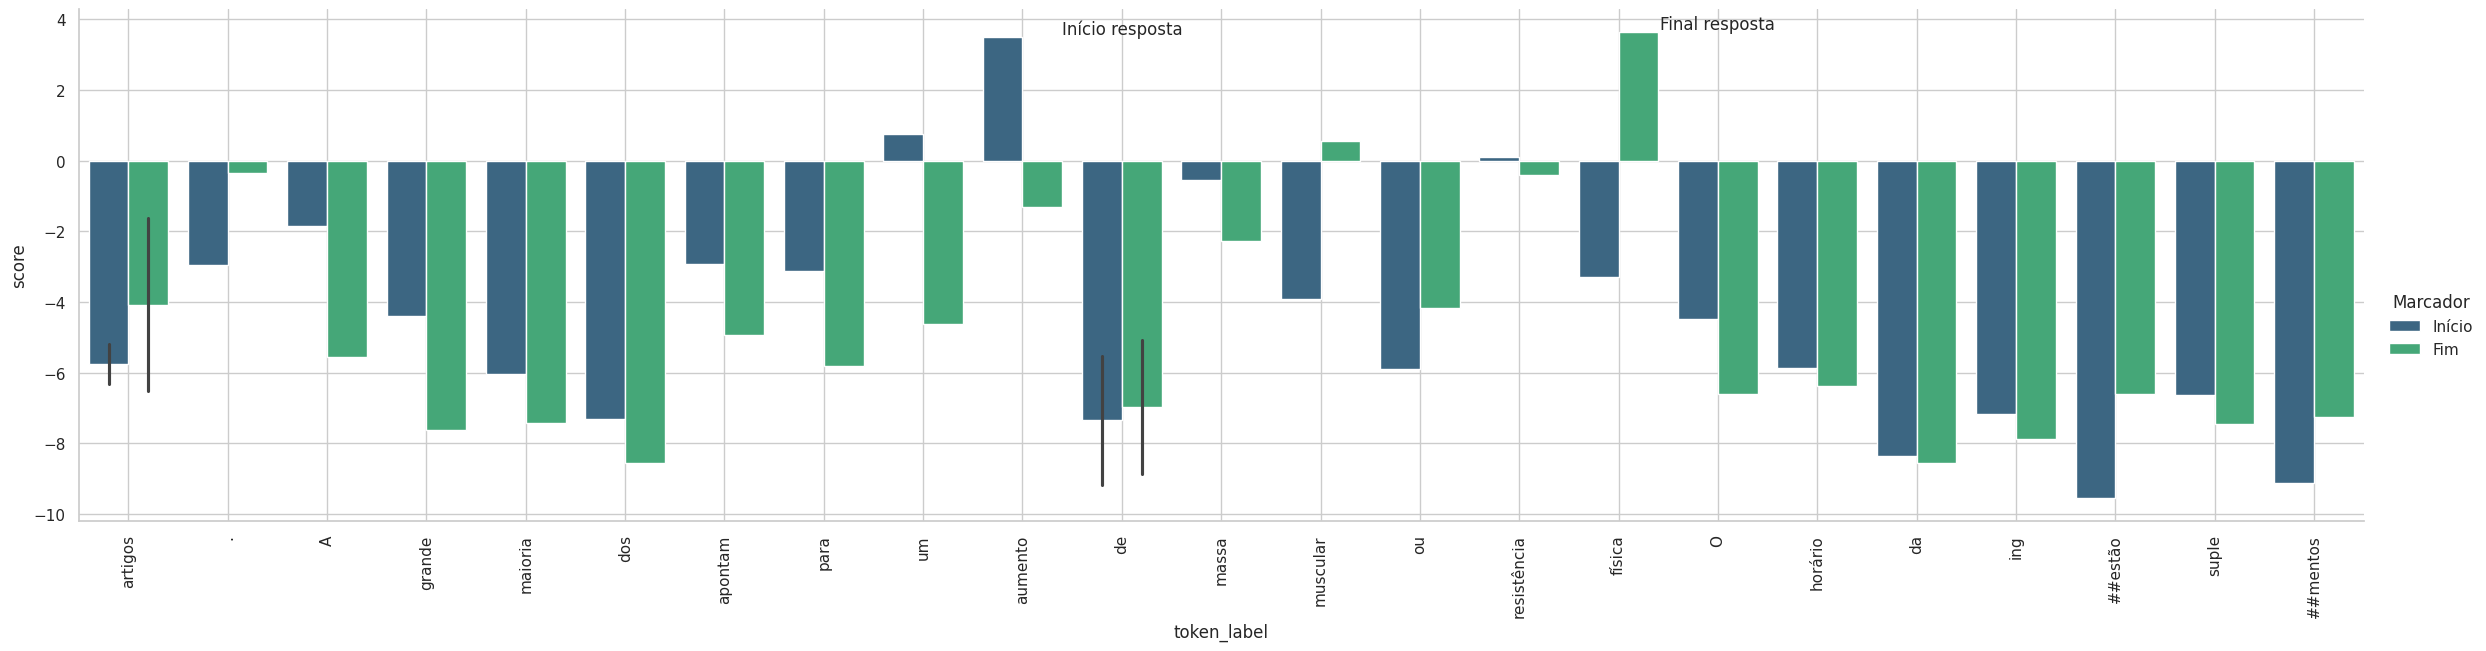

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

sb.set(style='whitegrid')
sb.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

# Preparar os dados
scores = []
for (i, token_label) in enumerate(tokens_viz):
    scores.append({'token_label': token_label, 'score': s_scores[i], 'Marcador': 'Início'})
    scores.append({'token_label': token_label, 'score': e_scores[i], 'Marcador': 'Fim'})

df = pd.DataFrame(scores)

# Identificar os maiores valores de cada marcador
max_start = df[df['Marcador'] == 'Início'].sort_values(by='score', ascending=False).iloc[0]
max_end = df[df['Marcador'] == 'Fim'].sort_values(by='score', ascending=False).iloc[0]

# Plotar o gráfico
sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (16, 8)

grafico = sns.catplot(x="token_label", y="score", hue="Marcador", data=df, kind="bar", height=6, aspect=4, palette="viridis")

# Adicionar setas para os maiores valores
ax = grafico.ax

# Encontrar as posições x para os labels
start_x = list(df[df['Marcador'] == 'Início'].index).index(max_start.name)
end_x = list(df[df['Marcador'] == 'Fim'].index).index(max_end.name)

ax.annotate('Início resposta', xy=(start_x, max_start['score']), xytext=(start_x, max_start['score'] + 0.1),
            arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center')

ax.annotate('Final resposta', xy=(end_x, max_end['score']), xytext=(end_x, max_end['score'] + 0.1),
            arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center')

# Ajustes finais
grafico.set_xticklabels(grafico.ax.get_xticklabels(), rotation=90, ha="center")
grafico.ax.grid(True)

plt.show()


In [ ]:
# recupera todo o intervalo do contexto que possui as miores probabilidades de iniciar e a de finalizar uma frase que representa a resposta
tokens[start_index:end_index+1]

['aumento', 'de', 'massa', 'muscular', 'ou', 'resistência', 'física']

## WebSocket

In [ ]:
def read_json_fields(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)

        if 'token' in data and 'domain' in data:
            return data['token'], data['domain']
        else:
            raise KeyError('JSON inválido.')

app = Flask(__name__)
app.config['SECRET_KEY'] = 'secret!'
socketio = SocketIO(app, cors_allowed_origins="*")

@app.route('/', methods=['GET'])
def home():
    return 'Olá! Esse é o WS.'

@socketio.on('EnviarMsg')
def obter_conteudo(data):
    pergunta = data["mensagem"]
    modo = data["modo"]

    print(f"Pergunta recebida: {pergunta}, Modo: {modo}")

    content = pipe.get_answer_to_question(pergunta, modo, )
    print(f'Tempo total de resposta: {content.total_time}s')

    resposta = {
                'mensagem': f'{content.answer.capitalize()}.',
                'tempoMsg': content.total_time
               }

    emit('msg_response', resposta)

@socketio.on('connect')
def handle_connect():
    print('Client connected')
    emit('connection_response', {'status': 'connected'})

@socketio.on('disconnect')
def handle_disconnect():
    print('Client disconnected')
    emit('connection_response', {'status': 'disconnected'})

token, hostname = read_json_fields(path_config_ws)
# Configuração do ngrok
ngrok.set_auth_token(token)
ngrok_tunnel = ngrok.connect(5000, bind_tls=True, hostname=hostname)
# public_url = ngrok_tunnel.public_url
# print(f"URL pública do aplicativo: {public_url}")

if __name__ == '__main__':
    socketio.run(app, port=5000, allow_unsafe_werkzeug=True)
